Time Series Analysis for Dynamical Systems


# 1. Problem Definition: Short Term Load Forecasting

Load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures.


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-09-13 13:01:42 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 1.67 s (started: 2024-09-13 13:01:42 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 1.97 s (started: 2024-09-13 13:01:44 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 78 ms (started: 2024-09-13 13:01:46 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 62 ms (started: 2024-09-13 13:01:46 +02:00)


# 3. Pre-processing


In [6]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:01:46 +02:00)


In [7]:
data = read_Data()

time: 32 ms (started: 2024-09-13 13:01:46 +02:00)


In [8]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 266 ms (started: 2024-09-13 13:01:46 +02:00)


# SVM I - Multi-step Forecasting: 

Multi-step forecasting involves predicting multiple future data points in the time series based on the previous data points. The model's objective is to predict a sequence of future values, given the historical data.

## Organizing the Feature Matrix

In [9]:
#Checking Data:
data.sample(3)

,load,T
2014-08-28 05:00:00,2930.0,65.33
2014-10-25 01:00:00,2531.0,46.33
2009-06-04 20:00:00,3359.0,67.67


time: 16 ms (started: 2024-09-13 13:01:46 +02:00)


In [10]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 31 ms (started: 2024-09-13 13:01:46 +02:00)


In [11]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.88271,21.33,2758.0


time: 15 ms (started: 2024-09-13 13:01:47 +02:00)


## Building the X Matrix and Labels

Adding the temporal data with sliding intervals in time. Lets first look with an illustration:

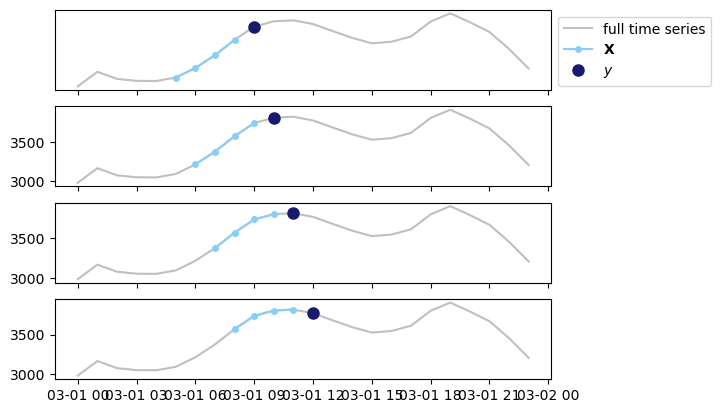

time: 656 ms (started: 2024-09-13 13:01:47 +02:00)


In [12]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create our feature matrix A in this way.

In [13]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 4
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 984 ms (started: 2024-09-13 13:01:47 +02:00)


#### Example:

   The purpose of this loop is to create sliding windows of data for the features (dataX) and the target variable (dataY).

    Let's say our new_dataframe looks like this (a simple example with 7 rows and 4 columns, including the target variable 'load'):

new_dataframe:
|    Date    | median_t | std_t | T_t | load |
|------------|----------|-------|-----|------|
| 2012-09-01 |        1 |     5 |   9 |   13 |
| 2012-09-02 |        2 |     6 |  10 |   14 |
| 2012-09-03 |        3 |     7 |  11 |   15 |
| 2012-09-04 |        4 |     8 |  12 |   16 |
| 2012-09-05 |        5 |     9 |  13 |   17 |
| 2012-09-06 |        6 |    10 |  14 |   18 |
| 2012-09-07 |        7 |    11 |  15 |   19 |

    And we set window = 3.

    Now, let's walk through the loop:

    i = start (i.e., the index of the first row)

    We create a window of size 3 for features:

    1  5  9
    2  6 10
    3  7 11
    We ravel this window into a single row:

    1  5  9  2  6 10  3  7 11
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 16) and add it to dataY.

    i = start + 1 (i.e., the index of the second row)

    We create a window of size 3 for features:

    2  6 10
    3  7 11
    4  8 12
    We ravel this window into a single row:

    2  6 10  3  7 11  4  8 12
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 17) and add it to dataY.

    The loop continues until i = end - window. After the loop, dataX and dataY will look like this:

dataX:
|    Date    | median_t_1 | std_t_1 | T_t_1 | median_t_2 | std_t_2 | T_t_2 | median_t_3 | std_t_3 | T_t_3 |
|------------|------------|---------|-------|------------|---------|-------|------------|---------|-------|
| 2012-09-04 |          1 |       5 |     9 |          2 |       6 |    10 |          3 |       7 |    11 |
| 2012-09-05 |          2 |       6 |    10 |          3 |       7 |    11 |          4 |       8 |    12 |

dataY:
|    Date    | load |
|------------|------|
| 2012-09-04 |   16 |
| 2012-09-05 |   17 |

    In this example, we have created a dataset with sliding windows of size 3, where each row in dataX contains the features from a window and the corresponding row in dataY contains the target variable ('load') right after that window.

    Increasing the value of the sliding window changes the amount of historical data being considered for each instance in the dataset. A larger sliding window size means that more past data points are being used to predict the target variable.

    In the context of your example, increasing the sliding window size to 48 would mean that each instance in dataX would have information from the 48 previous time steps. The physical meaning of this change depends on the temporal resolution of your data. For example, if your data is hourly, a sliding window of 48 would consider the past 48 hours of data for each prediction, while if the data is daily, it would consider the past 48 days.

    A larger sliding window size may capture longer-term patterns in the data, making it potentially more useful for predicting the target variable. However, it's important to note that increasing the sliding window size also increases the dimensionality of the input features, which can lead to a more complex model and may require more computational resources. Additionally, a larger window size may result in less training instances, as more data is required to form each instance.

    Ultimately, the optimal sliding window size depends on the specific problem and the nature of the data. It may be useful to experiment with different window sizes and evaluate the performance of the resulting models to find the best trade-off between capturing meaningful patterns in the data and maintaining a manageable input feature size.

In [14]:
#Original DF:
new_dataframe.loc['2014-09-01 00:00:00':'2014-09-04 00:00:00'].head(6)

,median,std,T,load
2014-09-01 00:00:00,3504.0,339.155815,69.67,3087.0
2014-09-01 01:00:00,3226.0,329.974115,71.00,2886.0
2014-09-01 02:00:00,2986.5,261.282095,70.00,2768.0
2014-09-01 03:00:00,2827.0,169.892123,69.33,2699.0
2014-09-01 04:00:00,2733.5,92.903175,68.33,2681.0
2014-09-01 05:00:00,2694.5,39.686270,68.33,2690.0


time: 16 ms (started: 2024-09-13 13:01:48 +02:00)


In [15]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
2012-09-01 04:00:00,3543.0,524.914199,59.33,2719.0,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0,2622.0,123.494939,67.67,2537.0


time: 0 ns (started: 2024-09-13 13:01:48 +02:00)


In [16]:
dataX.shape

(19052, 16)

time: 0 ns (started: 2024-09-13 13:01:48 +02:00)


In [17]:
dataY.head(2)

2012-09-01 04:00:00    2537.0
2012-09-01 05:00:00    2525.0
dtype: float64

time: 0 ns (started: 2024-09-13 13:01:48 +02:00)


In [18]:
dataY.shape

(19052,)

time: 0 ns (started: 2024-09-13 13:01:48 +02:00)


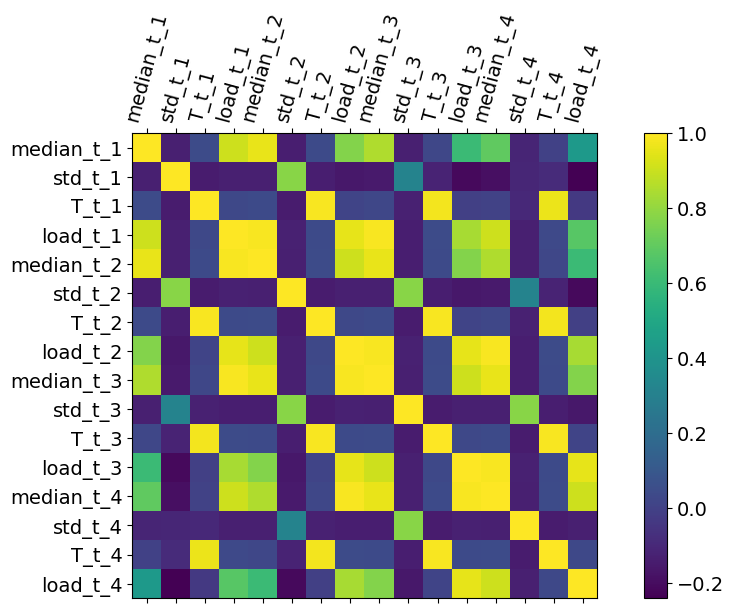

time: 265 ms (started: 2024-09-13 13:01:48 +02:00)


In [19]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [20]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
count,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04
mean,2.386875e-16,5.892597e-16,-3.329690e-15,-2.923921e-16,2.028843e-16,4.277727e-16,-3.544509e-15,9.845858e-17,-2.237695e-16,3.427403e-16,-3.520640e-15,-2.028843e-16,-1.670812e-16,1.834910e-16,-3.580312e-15,4.057687e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.356536e+00,-1.250854e+00,-3.150932e+00,-2.363943e+00,-2.356523e+00,-1.250961e+00,-3.150906e+00,-2.364070e+00,-2.356548e+00,-1.251018e+00,-3.150913e+00,-2.364173e+00,-2.356666e+00,-1.251030e+00,-3.150905e+00,-2.364310e+00
25%,-7.726966e-01,-8.791492e-01,-7.639865e-01,-7.721103e-01,-7.727081e-01,-8.791741e-01,-7.639432e-01,-7.722154e-01,-7.727602e-01,-8.791741e-01,-7.638814e-01,-7.722968e-01,-7.721740e-01,-8.791720e-01,-7.638207e-01,-7.723794e-01
50%,1.141806e-01,-3.143736e-01,9.416024e-02,1.191733e-01,1.141554e-01,-3.142749e-01,9.420957e-02,1.190803e-01,1.140882e-01,-3.141876e-01,9.429610e-02,1.190114e-01,1.140057e-01,-3.141646e-01,9.437566e-02,1.189593e-01
75%,6.730222e-01,7.707527e-01,7.982938e-01,6.788994e-01,6.729884e-01,7.708772e-01,7.983482e-01,6.788141e-01,6.729117e-01,7.710807e-01,7.984550e-01,6.787530e-01,6.728372e-01,7.711371e-01,7.985500e-01,6.787200e-01
max,3.458144e+00,4.153972e+00,2.446595e+00,3.420488e+00,3.458067e+00,4.155047e+00,2.446661e+00,3.420440e+00,3.457943e+00,4.155826e+00,2.446815e+00,3.420417e+00,3.457908e+00,4.156014e+00,2.446946e+00,3.420478e+00


time: 47 ms (started: 2024-09-13 13:01:49 +02:00)


    dataX is a 2-dimensional data structure (a pandas DataFrame) that contains input features for the model. Each row in dataX represents a window of the time series data, containing information like median temperature, standard deviation of temperature, and load for each time step within the window. The columns of dataX are named accordingly (e.g., 'median_t_1', 'std_t_1', 'T_t_1', 'load_t_1').

    dataY is a 1-dimensional data structure (a pandas Series) that contains the target values, which are the load values for the time step immediately following each window in dataX. The purpose of dataY is to provide the true load values that the model should predict based on the input features in dataX.

    Physically, dataX and dataY are in-memory data structures that hold information from the original time series data in a format suitable for training and evaluating a machine learning model. They are constructed using a sliding window approach, extracting relevant features and target values from the time series data to facilitate prediction tasks.

In [21]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (18980, 16) (18980,)
Test data shape:  (72, 16) (72,)
time: 0 ns (started: 2024-09-13 13:01:49 +02:00)


## Model Training and Predictions


In [22]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2024-09-13 13:01:49 +02:00)


In [23]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 12.2 s (started: 2024-09-13 13:01:49 +02:00)


In [24]:
#Model Predictions:
#------------------
scoreTraining = model.score(X_train, y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9643835749087722
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9650015835372014
-----------------------------------
time: 5.45 s (started: 2024-09-13 13:02:01 +02:00)


In [25]:
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 16 ms (started: 2024-09-13 13:02:06 +02:00)


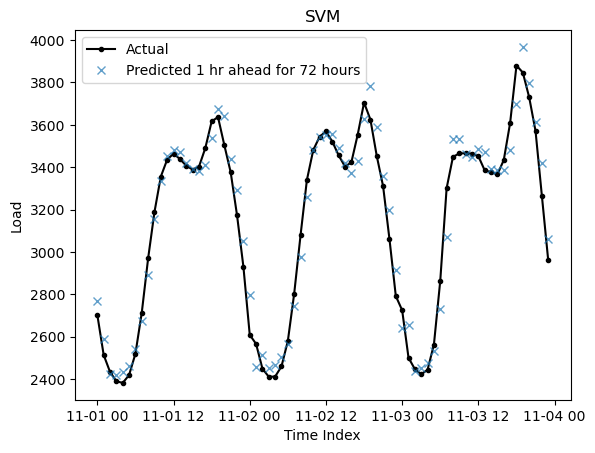

time: 187 ms (started: 2024-09-13 13:02:06 +02:00)


In [26]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');